In [1]:
import numpy as np
import matplotlib.pyplot as plt
import batman

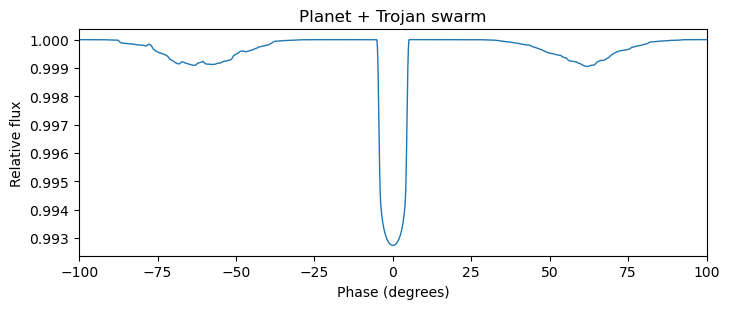

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import batman

np.random.seed(1)
# --- System + time grid ---
P, t0 = 5.0, 0.0           # days, reference mid-transit
a_rs, inc = 12.0, 88.5     # a/R*, inclination (deg)
u1, u2 = 0.3, 0.2          # limb darkening
rp_p = 0.08                # planet radius ratio
exp_time = 600/86400       # 10 min in days
supersample = 9
t = np.linspace(t0 - 1.5*P, t0 + 1.5*P, 40000)

def mk_params(t0_here, rp_here):
    p = batman.TransitParams()
    p.t0 = t0_here; p.per = P; p.rp = rp_here
    p.a = a_rs; p.inc = inc; p.ecc = 0.0; p.w = 90.0
    p.limb_dark = "quadratic"; p.u = [u1, u2]
    return p

# --- Planet-only model ---
pp = mk_params(t0, rp_p)
mp = batman.TransitModel(pp, t, supersample_factor=supersample, exp_time=exp_time)
flux = mp.light_curve(pp)

# --- Piecewise L4 Trojan size distribution (Dmin, Dmax, b) ---
segments = np.array([
    [ 2.0,  5.0, 1.3],   # 2–5 km,  b = 1.3
    [ 5.0, 10.0, 2.4],   # 5–10 km, b = 2.4
    [10.0, 93.0, 2.0],   # 10–93 km, b = 2.0
])

def sample_L4_diameters(n):
    Dmin, Dmax, b = segments.T
    q = b + 1.0                       # differential slope
    e = 1.0 - q
    # segment weights ∝ ∫ D^{-q} dD
    I = (Dmax**e - Dmin**e) / e
    p = I / I.sum()
    seg = np.random.choice(len(segments), size=n, p=p)
    D = np.empty(n)
    for i in range(len(segments)):
        m = (seg == i)
        if not m.any():
            continue
        Di, Dx, bi = segments[i]
        qi = bi + 1.0; ei = 1.0 - qi
        u = np.random.rand(m.sum())
        Di_e, Dx_e = Di**ei, Dx**ei
        D[m] = (u*(Dx_e - Di_e) + Di_e)**(1.0/ei)
    return D

# --- Trojan swarm geometry + sizes ---
N_swarm, frac_L4, sigma_deg = 10000, 0.5, 10.0
nL4 = int(N_swarm * frac_L4)
nL5 = N_swarm - nL4

angles = np.concatenate([
    np.random.normal( 60.0, sigma_deg, nL4),   # around L4
    np.random.normal(-60.0, sigma_deg, nL5),   # around L5
])

D_km = sample_L4_diameters(N_swarm)           # piecewise power law in D
R_troj = D_km / 2.0
# rescale to keep relative distribution but make transits visible
rp_T = (R_troj / R_troj.max()) * 0.01

dt = (angles / 360.0) * P
t0_T = t0 + dt

# --- Multiply Trojan transits onto the star ---
for t0_i, rp_i in zip(t0_T, rp_T):
    pT = mk_params(t0_i, rp_i)
    mT = batman.TransitModel(pT, t, supersample_factor=supersample, exp_time=exp_time)
    flux *= mT.light_curve(pT)

# --- Plot phase-folded light curve ---
phase_deg = (t - t0) / P * 360.0
mask = (phase_deg >= -100) & (phase_deg <= 100)

plt.figure(figsize=(7.4, 3.2))
plt.plot(phase_deg[mask], flux[mask], lw=1)
plt.xlabel("Phase (degrees)")
plt.ylabel("Relative flux")
plt.xlim(-100, 100)
plt.title(f"Planet + Trojan swarm")
plt.tight_layout()
plt.show()